In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-06-01 15:50:07--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  11.6MB/s    in 28s     

2022-06-01 15:50:35 (11.3 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [11]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(1000,100000),cutout_ratio=[(0,1)]),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [12]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [13]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1'

In [14]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [15]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-06-01 15:50:36,929 - mmseg - INFO - Loaded 537 images
2022-06-01 15:50:40,656 - mmseg - INFO - Loaded 113 images
2022-06-01 15:50:40,659 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-06-01 15:50:41,166 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-06-01 15:50:41,172 - mmseg - INFO - Start running, host: root@3d999f584d86, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1
2022-06-01 15:50:41,173 - mmseg - INFO - Hooks will be exec

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 471s, ETA:     0s

2022-06-01 16:15:58,969 - mmseg - INFO - per class results:
2022-06-01 16:15:58,971 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.58 | 92.21 |
|  building  | 68.89 | 77.84 |
|  Boundary  | 45.55 | 69.31 |
+------------+-------+-------+
2022-06-01 16:15:58,973 - mmseg - INFO - Summary:
2022-06-01 16:15:58,975 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 85.52 | 67.0 | 79.79 |
+-------+------+-------+
2022-06-01 16:15:58,978 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8552, mIoU: 0.6700, mAcc: 0.7979, IoU.background: 0.8658, IoU.building: 0.6889, IoU.Boundary: 0.4555, Acc.background: 0.9221, Acc.building: 0.7784, Acc.Boundary: 0.6931
2022-06-01 16:17:40,153 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 7:43:35, time: 5.720, data_time: 5.412, memory: 3323, decode.loss_dice: 0.2086, decode.loss_focal: 0.0481, decode.loss_lovasz: 0.3854, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-01 16:41:21,899 - mmseg - INFO - per class results:
2022-06-01 16:41:21,902 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.14 | 88.89 |
|  building  | 74.34 | 91.18 |
|  Boundary  | 45.22 | 65.69 |
+------------+-------+-------+
2022-06-01 16:41:21,903 - mmseg - INFO - Summary:
2022-06-01 16:41:21,907 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 86.2 | 68.57 | 81.92 |
+------+-------+-------+
2022-06-01 16:41:21,910 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8620, mIoU: 0.6857, mAcc: 0.8192, IoU.background: 0.8614, IoU.building: 0.7434, IoU.Boundary: 0.4522, Acc.background: 0.8889, Acc.building: 0.9118, Acc.Boundary: 0.6569
2022-06-01 16:42:53,728 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 7:25:00, time: 5.235, data_time: 4.927, memory: 3323, decode.loss_dice: 0.1710, decode.loss_focal: 0.0394, decode.loss_lovasz: 0.3337, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-01 17:05:05,905 - mmseg - INFO - per class results:
2022-06-01 17:05:05,907 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.59 | 88.84 |
|  building  |  74.1 | 91.12 |
|  Boundary  | 48.08 | 69.29 |
+------------+-------+-------+
2022-06-01 17:05:05,908 - mmseg - INFO - Summary:
2022-06-01 17:05:05,912 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.66 | 69.59 | 83.08 |
+-------+-------+-------+
2022-06-01 17:05:05,914 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8666, mIoU: 0.6959, mAcc: 0.8308, IoU.background: 0.8659, IoU.building: 0.7410, IoU.Boundary: 0.4808, Acc.background: 0.8884, Acc.building: 0.9112, Acc.Boundary: 0.6929
2022-06-01 17:06:45,646 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 6:54:43, time: 5.315, data_time: 5.009, memory: 3323, decode.loss_dice: 0.1712, decode.loss_focal: 0.0402, decode.loss_lovasz: 0.3330, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-01 17:30:20,937 - mmseg - INFO - per class results:
2022-06-01 17:30:20,938 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.48 | 94.19 |
|  building  | 76.57 | 86.08 |
|  Boundary  | 51.22 | 69.46 |
+------------+-------+-------+
2022-06-01 17:30:20,942 - mmseg - INFO - Summary:
2022-06-01 17:30:20,943 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.76 | 72.42 | 83.24 |
+-------+-------+-------+
2022-06-01 17:30:20,947 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8876, mIoU: 0.7242, mAcc: 0.8324, IoU.background: 0.8948, IoU.building: 0.7657, IoU.Boundary: 0.5122, Acc.background: 0.9419, Acc.building: 0.8608, Acc.Boundary: 0.6946
2022-06-01 17:32:13,147 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 6:33:44, time: 5.441, data_time: 5.132, memory: 3323, decode.loss_dice: 0.1660, decode.loss_focal: 0.0409, decode.loss_lovasz: 0.3272, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 17:55:00,805 - mmseg - INFO - per class results:
2022-06-01 17:55:00,807 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.21 | 93.32 |
|  building  |  76.5 | 88.01 |
|  Boundary  | 51.42 | 69.21 |
+------------+-------+-------+
2022-06-01 17:55:00,809 - mmseg - INFO - Summary:
2022-06-01 17:55:00,813 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.66 | 72.37 | 83.51 |
+-------+-------+-------+
2022-06-01 17:55:00,815 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8866, mIoU: 0.7237, mAcc: 0.8351, IoU.background: 0.8921, IoU.building: 0.7650, IoU.Boundary: 0.5142, Acc.background: 0.9332, Acc.building: 0.8801, Acc.Boundary: 0.6921
2022-06-01 17:56:35,069 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 6:07:48, time: 5.235, data_time: 4.926, memory: 3323, decode.loss_dice: 0.1564, decode.loss_focal: 0.0370, decode.loss_lovasz: 0.3131, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 18:18:28,727 - mmseg - INFO - per class results:
2022-06-01 18:18:28,729 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.72 | 92.31 |
|  building  | 77.01 | 87.08 |
|  Boundary  | 51.49 | 73.35 |
+------------+-------+-------+
2022-06-01 18:18:28,731 - mmseg - INFO - Summary:
2022-06-01 18:18:28,733 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.39 | 72.41 | 84.25 |
+-------+-------+-------+
2022-06-01 18:18:28,738 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8839, mIoU: 0.7241, mAcc: 0.8425, IoU.background: 0.8872, IoU.building: 0.7701, IoU.Boundary: 0.5149, Acc.background: 0.9231, Acc.building: 0.8708, Acc.Boundary: 0.7335
2022-06-01 18:19:56,651 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 5:40:06, time: 5.171, data_time: 4.863, memory: 3323, decode.loss_dice: 0.1553, decode.loss_focal: 0.0372, decode.loss_lovasz: 0.3142, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 18:41:47,089 - mmseg - INFO - per class results:
2022-06-01 18:41:47,091 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.85 | 94.43 |
|  building  | 77.76 | 86.35 |
|  Boundary  | 52.65 | 71.24 |
+------------+-------+-------+
2022-06-01 18:41:47,094 - mmseg - INFO - Summary:
2022-06-01 18:41:47,096 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.23 | 73.42 | 84.01 |
+-------+-------+-------+
2022-06-01 18:41:47,098 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8923, mIoU: 0.7342, mAcc: 0.8401, IoU.background: 0.8985, IoU.building: 0.7776, IoU.Boundary: 0.5265, Acc.background: 0.9443, Acc.building: 0.8635, Acc.Boundary: 0.7124
2022-06-01 18:43:15,623 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 5:13:32, time: 5.179, data_time: 4.870, memory: 3323, decode.loss_dice: 0.1455, decode.loss_focal: 0.0365, decode.loss_lovasz: 0.2967, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 19:07:17,980 - mmseg - INFO - per class results:
2022-06-01 19:07:17,981 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.63 | 93.22 |
|  building  | 77.63 | 87.99 |
|  Boundary  | 52.13 | 71.93 |
+------------+-------+-------+
2022-06-01 19:07:17,983 - mmseg - INFO - Summary:
2022-06-01 19:07:17,985 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.97 | 73.13 | 84.38 |
+-------+-------+-------+
2022-06-01 19:07:17,989 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8897, mIoU: 0.7313, mAcc: 0.8438, IoU.background: 0.8963, IoU.building: 0.7763, IoU.Boundary: 0.5213, Acc.background: 0.9322, Acc.building: 0.8799, Acc.Boundary: 0.7193
2022-06-01 19:09:05,493 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 4:51:28, time: 5.368, data_time: 5.060, memory: 3323, decode.loss_dice: 0.1418, decode.loss_focal: 0.0349, decode.loss_lovasz: 0.2930, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 19:32:10,444 - mmseg - INFO - per class results:
2022-06-01 19:32:10,446 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.19 | 95.01 |
|  building  | 77.83 | 85.55 |
|  Boundary  | 53.26 | 71.68 |
+------------+-------+-------+
2022-06-01 19:32:10,447 - mmseg - INFO - Summary:
2022-06-01 19:32:10,449 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.45 | 73.76 | 84.08 |
+-------+-------+-------+
2022-06-01 19:32:10,453 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8945, mIoU: 0.7376, mAcc: 0.8408, IoU.background: 0.9019, IoU.building: 0.7783, IoU.Boundary: 0.5326, Acc.background: 0.9501, Acc.building: 0.8555, Acc.Boundary: 0.7168
2022-06-01 19:33:44,779 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 4:27:10, time: 5.236, data_time: 4.927, memory: 3323, decode.loss_dice: 0.1498, decode.loss_focal: 0.0376, decode.loss_lovasz: 0.3021, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 19:57:06,828 - mmseg - INFO - per class results:
2022-06-01 19:57:06,830 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.95 | 94.15 |
|  building  | 78.18 | 86.74 |
|  Boundary  | 53.14 | 72.61 |
+------------+-------+-------+
2022-06-01 19:57:06,832 - mmseg - INFO - Summary:
2022-06-01 19:57:06,833 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.34 | 73.76 | 84.5 |
+-------+-------+------+
2022-06-01 19:57:06,838 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8934, mIoU: 0.7376, mAcc: 0.8450, IoU.background: 0.8995, IoU.building: 0.7818, IoU.Boundary: 0.5314, Acc.background: 0.9415, Acc.building: 0.8674, Acc.Boundary: 0.7261
2022-06-01 19:58:47,083 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 4:03:11, time: 5.297, data_time: 4.987, memory: 3323, decode.loss_dice: 0.1320, decode.loss_focal: 0.0309, decode.loss_lovasz: 0.2752, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 20:21:37,706 - mmseg - INFO - per class results:
2022-06-01 20:21:37,708 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.47 |  94.1 |
|  building  |  78.4 | 87.36 |
|  Boundary  | 54.11 | 73.86 |
+------------+-------+-------+
2022-06-01 20:21:37,709 - mmseg - INFO - Summary:
2022-06-01 20:21:37,711 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.63 | 74.32 | 85.11 |
+-------+-------+-------+
2022-06-01 20:21:37,715 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8963, mIoU: 0.7432, mAcc: 0.8511, IoU.background: 0.9047, IoU.building: 0.7840, IoU.Boundary: 0.5411, Acc.background: 0.9410, Acc.building: 0.8736, Acc.Boundary: 0.7386
2022-06-01 20:23:24,495 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 3:38:40, time: 5.361, data_time: 5.051, memory: 3323, decode.loss_dice: 0.1358, decode.loss_focal: 0.0320, decode.loss_lovasz: 0.2794, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-06-01 20:45:43,989 - mmseg - INFO - per class results:
2022-06-01 20:45:43,991 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.38 | 94.06 |
|  building  | 79.13 | 89.14 |
|  Boundary  | 53.32 | 71.35 |
+------------+-------+-------+
2022-06-01 20:45:43,995 - mmseg - INFO - Summary:
2022-06-01 20:45:43,997 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.69 | 74.28 | 84.85 |
+-------+-------+-------+
2022-06-01 20:45:44,003 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8969, mIoU: 0.7428, mAcc: 0.8485, IoU.background: 0.9038, IoU.building: 0.7913, IoU.Boundary: 0.5332, Acc.background: 0.9406, Acc.building: 0.8914, Acc.Boundary: 0.7135
2022-06-01 20:47:22,981 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 3:13:42, time: 5.291, data_time: 4.982, memory: 3323, decode.loss_dice: 0.1390, decode.loss_focal: 0.0355, decode.loss_lovasz: 0.2856, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 21:11:10,085 - mmseg - INFO - per class results:
2022-06-01 21:11:10,086 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.8 | 95.05 |
|  building  | 78.56 | 86.78 |
|  Boundary  | 53.69 | 71.93 |
+------------+-------+-------+
2022-06-01 21:11:10,088 - mmseg - INFO - Summary:
2022-06-01 21:11:10,090 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.81 | 74.35 | 84.59 |
+-------+-------+-------+
2022-06-01 21:11:10,094 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8981, mIoU: 0.7435, mAcc: 0.8459, IoU.background: 0.9080, IoU.building: 0.7856, IoU.Boundary: 0.5369, Acc.background: 0.9505, Acc.building: 0.8678, Acc.Boundary: 0.7193
2022-06-01 21:12:50,652 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 2:49:41, time: 5.299, data_time: 4.989, memory: 3323, decode.loss_dice: 0.1327, decode.loss_focal: 0.0327, decode.loss_lovasz: 0.2801, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 21:36:02,978 - mmseg - INFO - per class results:
2022-06-01 21:36:02,981 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.57 | 94.03 |
|  building  | 79.33 |  88.5 |
|  Boundary  | 54.32 | 73.71 |
+------------+-------+-------+
2022-06-01 21:36:02,983 - mmseg - INFO - Summary:
2022-06-01 21:36:02,986 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.84 | 74.74 | 85.41 |
+-------+-------+-------+
2022-06-01 21:36:02,991 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8984, mIoU: 0.7474, mAcc: 0.8541, IoU.background: 0.9057, IoU.building: 0.7933, IoU.Boundary: 0.5432, Acc.background: 0.9403, Acc.building: 0.8850, Acc.Boundary: 0.7371
2022-06-01 21:37:46,787 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 2:25:14, time: 5.331, data_time: 5.020, memory: 3323, decode.loss_dice: 0.1271, decode.loss_focal: 0.0334, decode.loss_lovasz: 0.2691, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 22:00:40,420 - mmseg - INFO - per class results:
2022-06-01 22:00:40,422 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.61 | 94.95 |
|  building  | 78.63 | 86.84 |
|  Boundary  | 54.27 | 72.44 |
+------------+-------+-------+
2022-06-01 22:00:40,424 - mmseg - INFO - Summary:
2022-06-01 22:00:40,426 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.83 | 74.51 | 84.74 |
+-------+-------+-------+
2022-06-01 22:00:40,428 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8983, mIoU: 0.7451, mAcc: 0.8474, IoU.background: 0.9061, IoU.building: 0.7863, IoU.Boundary: 0.5427, Acc.background: 0.9495, Acc.building: 0.8684, Acc.Boundary: 0.7244
2022-06-01 22:02:35,672 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 2:00:41, time: 5.446, data_time: 5.136, memory: 3323, decode.loss_dice: 0.1265, decode.loss_focal: 0.0303, decode.loss_lovasz: 0.2691, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 22:26:24,337 - mmseg - INFO - per class results:
2022-06-01 22:26:24,340 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.81 | 94.67 |
|  building  | 79.32 | 87.89 |
|  Boundary  | 54.45 | 72.97 |
+------------+-------+-------+
2022-06-01 22:26:24,341 - mmseg - INFO - Summary:
2022-06-01 22:26:24,345 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.99 | 74.86 | 85.18 |
+-------+-------+-------+
2022-06-01 22:26:24,347 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8999, mIoU: 0.7486, mAcc: 0.8518, IoU.background: 0.9081, IoU.building: 0.7932, IoU.Boundary: 0.5445, Acc.background: 0.9467, Acc.building: 0.8789, Acc.Boundary: 0.7297
2022-06-01 22:28:03,825 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 1:36:15, time: 5.289, data_time: 4.981, memory: 3323, decode.loss_dice: 0.1284, decode.loss_focal: 0.0308, decode.loss_lovasz: 0.2700, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 22:51:40,235 - mmseg - INFO - per class results:
2022-06-01 22:51:40,237 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.54 | 93.84 |
|  building  | 79.19 | 88.08 |
|  Boundary  | 54.58 | 74.97 |
+------------+-------+-------+
2022-06-01 22:51:40,240 - mmseg - INFO - Summary:
2022-06-01 22:51:40,241 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.8 | 74.77 | 85.63 |
+------+-------+-------+
2022-06-01 22:51:40,245 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8980, mIoU: 0.7477, mAcc: 0.8563, IoU.background: 0.9054, IoU.building: 0.7919, IoU.Boundary: 0.5458, Acc.background: 0.9384, Acc.building: 0.8808, Acc.Boundary: 0.7497
2022-06-01 22:53:23,458 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 1:11:41, time: 5.326, data_time: 5.015, memory: 3323, decode.loss_dice: 0.1263, decode.loss_focal: 0.0303, decode.loss_lovasz: 0.2649, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 23:16:10,218 - mmseg - INFO - per class results:
2022-06-01 23:16:10,220 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.64 | 94.07 |
|  building  | 79.54 | 89.74 |
|  Boundary  | 53.97 | 71.85 |
+------------+-------+-------+
2022-06-01 23:16:10,222 - mmseg - INFO - Summary:
2022-06-01 23:16:10,227 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.91 | 74.72 | 85.22 |
+-------+-------+-------+
2022-06-01 23:16:10,228 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8991, mIoU: 0.7472, mAcc: 0.8522, IoU.background: 0.9064, IoU.building: 0.7954, IoU.Boundary: 0.5397, Acc.background: 0.9407, Acc.building: 0.8974, Acc.Boundary: 0.7185
2022-06-01 23:17:49,157 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:46:56, time: 5.283, data_time: 4.972, memory: 3323, decode.loss_dice: 0.1168, decode.loss_focal: 0.0291, decode.loss_lovasz: 0.2523, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-01 23:40:29,700 - mmseg - INFO - per class results:
2022-06-01 23:40:29,703 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.52 |  93.7 |
|  building  |  79.6 | 89.25 |
|  Boundary  | 54.41 | 73.97 |
+------------+-------+-------+
2022-06-01 23:40:29,705 - mmseg - INFO - Summary:
2022-06-01 23:40:29,706 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.86 | 74.84 | 85.64 |
+-------+-------+-------+
2022-06-01 23:40:29,708 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8986, mIoU: 0.7484, mAcc: 0.8564, IoU.background: 0.9052, IoU.building: 0.7960, IoU.Boundary: 0.5441, Acc.background: 0.9370, Acc.building: 0.8925, Acc.Boundary: 0.7397
2022-06-01 23:42:09,734 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:22:12, time: 5.294, data_time: 4.984, memory: 3323, decode.loss_dice: 0.1167, decode.loss_focal: 0.0261, decode.loss_lovasz: 0.2495, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-02 00:04:27,546 - mmseg - INFO - per class results:
2022-06-02 00:04:27,549 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.82 | 94.39 |
|  building  | 79.61 |  89.5 |
|  Boundary  | 54.26 | 71.78 |
+------------+-------+-------+
2022-06-02 00:04:27,552 - mmseg - INFO - Summary:
2022-06-02 00:04:27,554 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 90.04 | 74.9 | 85.22 |
+-------+------+-------+
2022-06-02 00:04:27,556 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9004, mIoU: 0.7490, mAcc: 0.8522, IoU.background: 0.9082, IoU.building: 0.7961, IoU.Boundary: 0.5426, Acc.background: 0.9439, Acc.building: 0.8950, Acc.Boundary: 0.7178


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


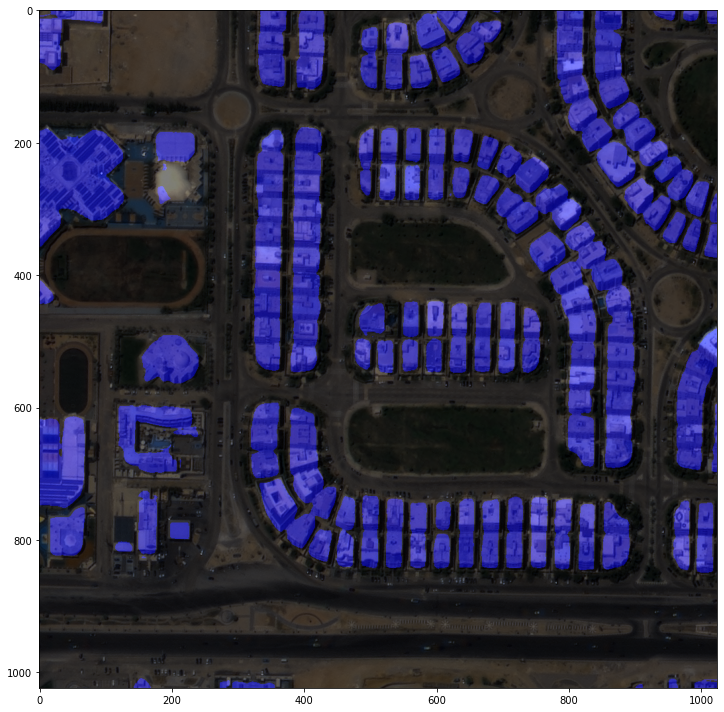

In [16]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


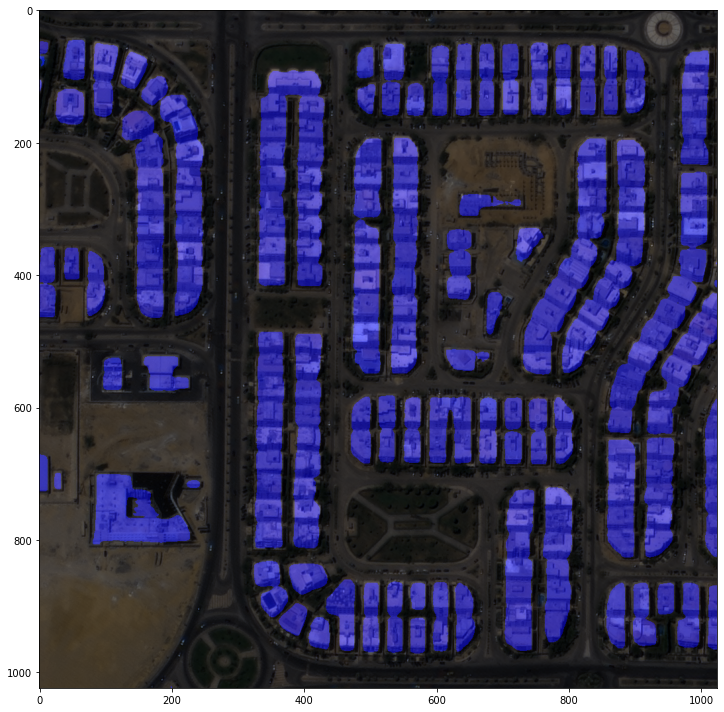

In [17]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


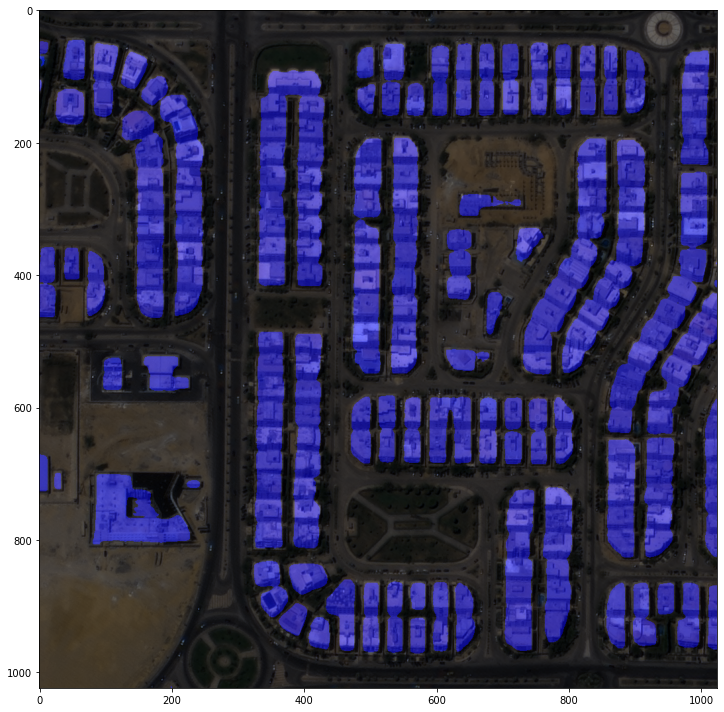

In [18]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


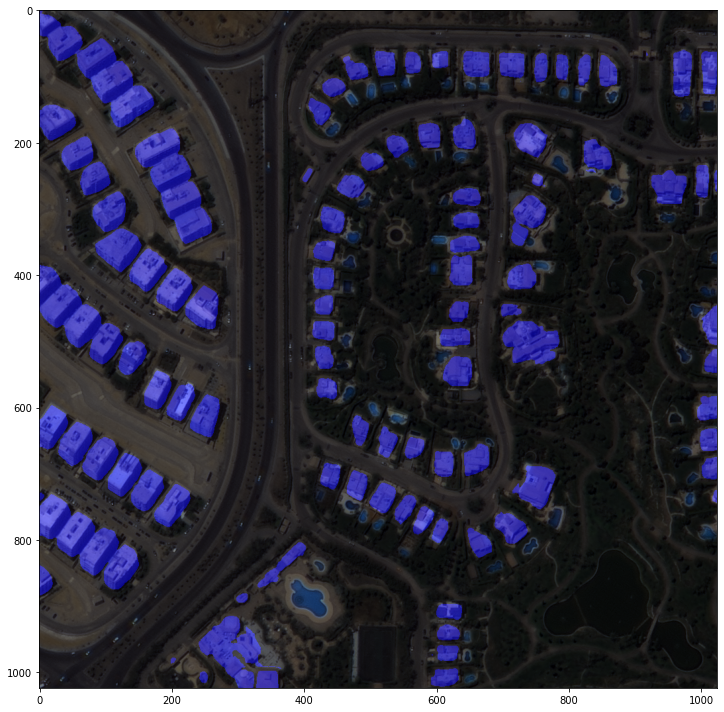

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


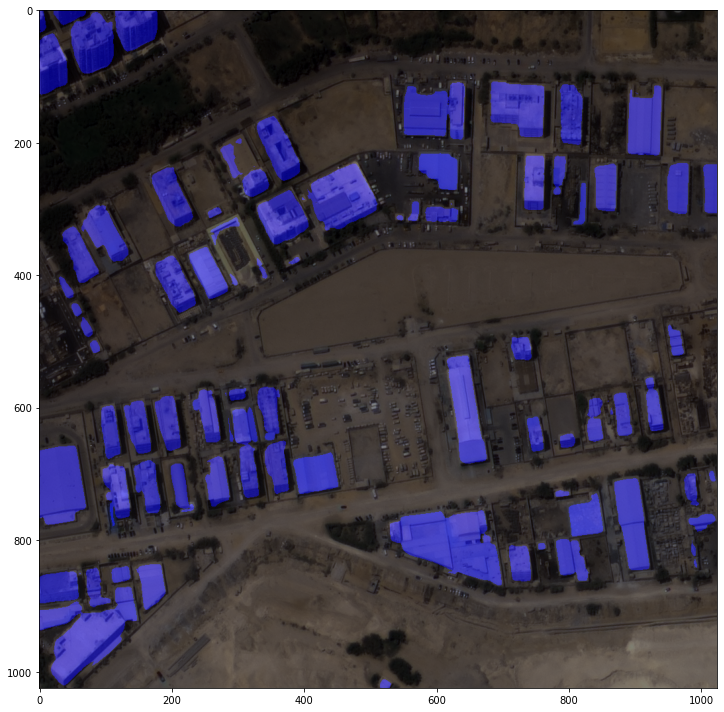

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


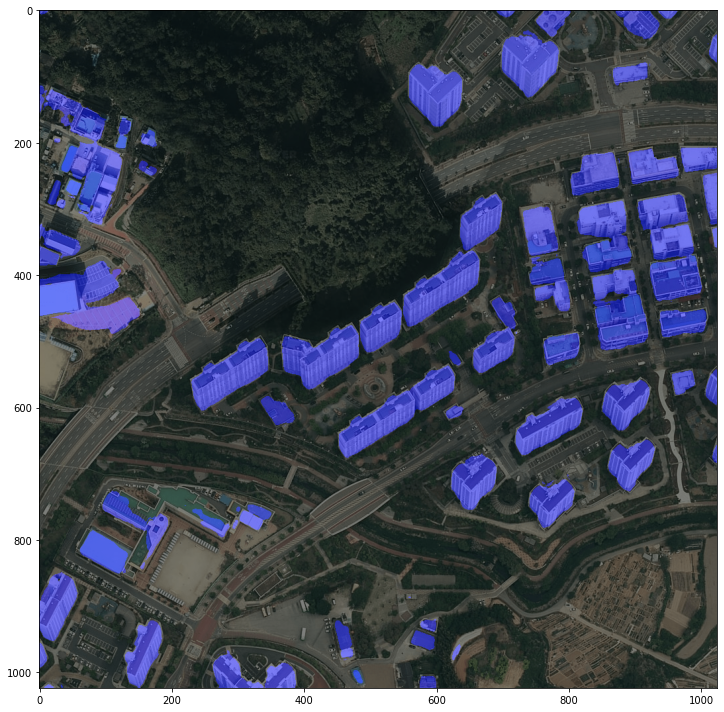

In [21]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


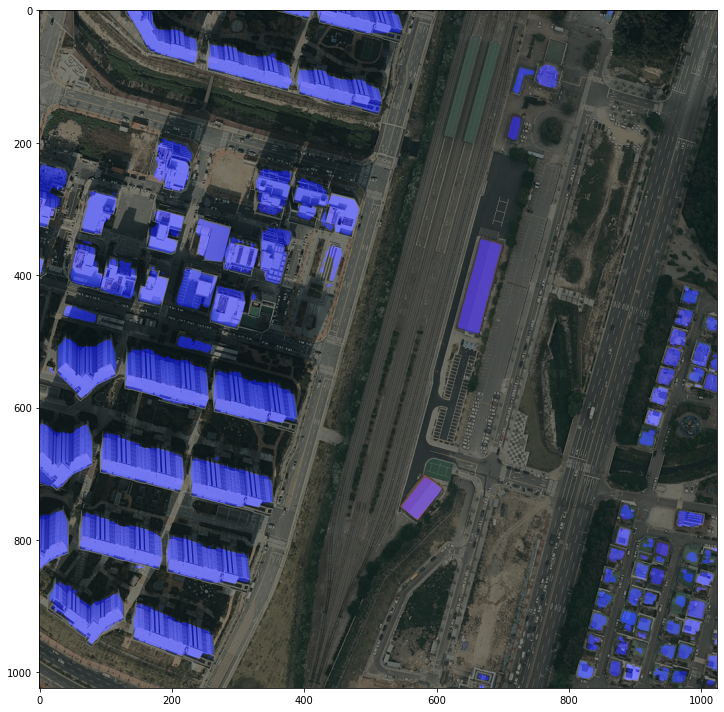

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


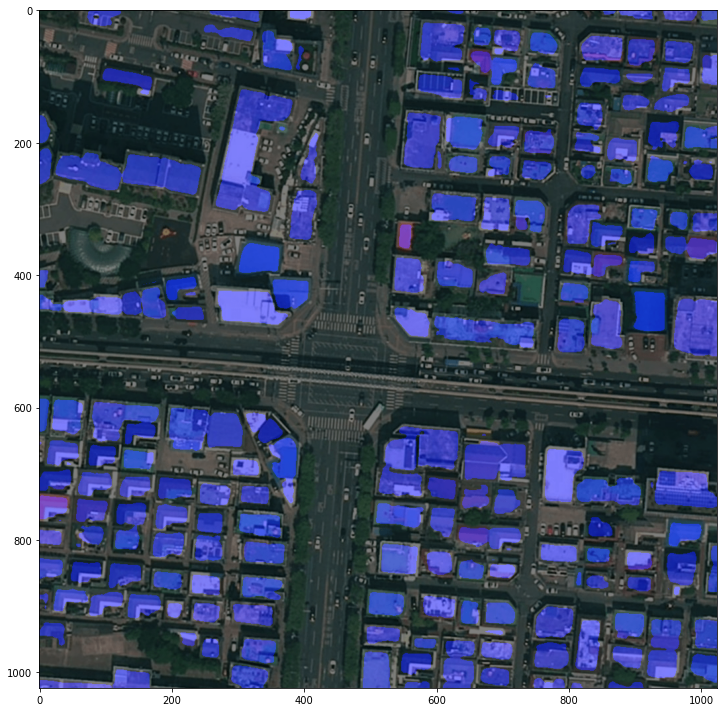

In [23]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
import os
file_list = os.listdir('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val')
test_png = []
for i in file_list:
  if '.png' in i:
    test_png.append(i)

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_100000_0_1/iter_20000.pth'  #학습된 모델
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

for j in test_png:
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/'+j)
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img, result, palette)

Output hidden; open in https://colab.research.google.com to view.